<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_22/blob/main/Assignments/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 3


## Important notes

**Submission deadline:**
**lab session in the week of 24-28 of October 2022**

**Points: 3+2+2=7**

Please let us know about any problems with it - we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

## k-Nearest Neighbors

We will use the loaded Iris data describing iris flowers
and shows relations between their length and petal width for three
species (namely: setosa, versicolor, virginica).

For this exercise we will restrict our analysis to just two variables: **petal length** and **petal width**.

In [1]:
# Standard IPython notebook imports
%matplotlib inline

import os

import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import scipy.stats as sstats

import seaborn as sns
from sklearn import datasets

# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat

sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

In [2]:
iris_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
# Use read_csv to load the data. Make sure you get 150 examples!
iris_df = pd.read_csv(iris_url, header=None)
print(len(iris_df))

# Set the column names to
# 'sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target'
iris_df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target']

# Print the first 10 entries
iris_df.head(10)


150


,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


<AxesSubplot:xlabel='petal_length', ylabel='petal_width'>

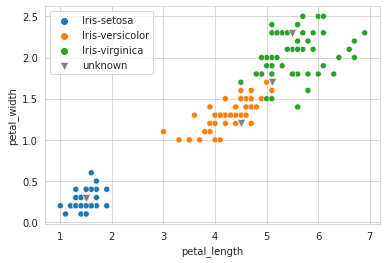

In [3]:
unknown_df = pd.DataFrame(
    [[1.5, 0.3, 'unknown'],
     [4.5, 1.2, 'unknown'],
     [5.1, 1.7, 'unknown'],
     [5.5, 2.3, 'unknown']],
     columns=['petal_length', 'petal_width', 'target'])

sns.scatterplot(x='petal_length', y='petal_width', hue='target', data=iris_df)
sns.scatterplot(x='petal_length', y='petal_width', color='gray', marker='v',
                label='unknown', s=70, data=unknown_df)

Based on these two features, it is easy to distinguish iris setosa from the two remaining species. Yet iris versicolor and virginica remain mixed together. 

Looking closely at the plot, we might estimate the species of the selected unknown irises (gray triangles). For three of them the answer seems obvious – they belong in uniformly-colored areas covered by one species only. Yet unknown iris flower in (5.1, 1.7) is troublesome – it lays on the boundary of versicolor and virginica clusters. We can assume, that its species is the one of the closest one to it, coming from the training set (and so having a label). 

K-Nearest Neighbors method (http://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) solves the classification problem, i.e. sets class labels (species in case of irises) of a previously unseen sample by choosing the most common class among the top k neighbors of the sample in question (for instance according to the Euclidean distance). Thus, the k-Nearest Neighbors algorithm works as follows. For each unlabeled sample x:
1. Find k nearest neighbors among the labeled samples.
2. Set the most common label among them as label of x.

## Problem 1 kNN Iris [3p]

### Implement the k-Nearest Neighbors algorithm [1p].

Take advantage of matrix calculus rather than using for loops. (Although you will earn 0.5 points, if you will use for loops, but still provide a good classifier)

**Tip:** What is computed by \begin{equation} \sqrt{(X - Y)^T (X - Y)} \end{equation} when both X and Y are vectors?

**Tip:** Try to use broadcasting (NumPy: http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) and built-ins sort, numpy.sort, numpy.argsort (sorting), scipy.stats.mode (choosing the most common element of the set).

In [4]:
def KNN(train_X, train_Y, test_X, ks, verbose=False):
    """
    Compute predictions for various k
    Args:
        train_X: array of shape Ntrain x D
        train_Y: array of shape Ntrain
        test_X: array of shape Ntest x D
        ks: list of integers
    Returns:
        preds: dict k: predictions for k
    """
    # Cats data to float32
    train_X = train_X.astype(np.float32)
    test_X = test_X.astype(np.float32)

    # Alloc space for results
    preds = {}

    if verbose:
        print("Computing distances... ", end='')
    #
    # TODO: fill in an efficient distance matrix computation
    #    
    # (x1 - y1)^2 + (x2 - y2)^2 = x1^2 + y1^2 + x2^2 + y2^2 - 2(x1y1 + x2y2)
    dists = -2 * (train_X.dot(test_X.T)) + np.sum(train_X ** 2, axis=1)[:, np.newaxis] + np.sum(test_X ** 2, axis=1)

    if verbose:
        print("Sorting... ", end='')
    
    # TODO: findes closest trainig points
    # Hint: use np.argsort
    closest = np.argsort(dists, axis=0)


    if verbose:
        print("Computing predictions...", end='')
    
    targets = train_Y[closest]
    for k in ks:
        predictions = sstats.mode(targets[:k])[0]
        predictions = predictions.ravel()
        preds[k] = predictions
    if verbose:
        print("Done")
    return preds


In [5]:
# Now classify the 4 unknown points
iris_x = np.array(iris_df[['petal_length', 'petal_width']])
iris_y = np.array(iris_df['target'])

unknown_x = np.array(unknown_df[['petal_length', 'petal_width']])

KNN(iris_x, iris_y, unknown_x, [1, 3, 5, 7])

{1: array(['Iris-setosa', 'Iris-versicolor', 'Iris-versicolor',
        'Iris-virginica'], dtype=object),
 3: array(['Iris-setosa', 'Iris-versicolor', 'Iris-versicolor',
        'Iris-virginica'], dtype=object),
 5: array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica',
        'Iris-virginica'], dtype=object),
 7: array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica',
        'Iris-virginica'], dtype=object)}

### Plot the Decision boundary [1p]


Use meshgrid to generate the points in the space spanned by data.
Then map the classes to numbers 0, 1, 2 and make a contour plot with the
decision boundary.

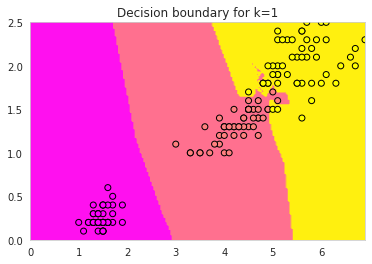

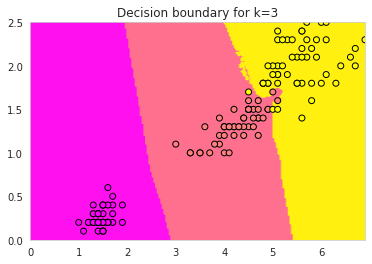

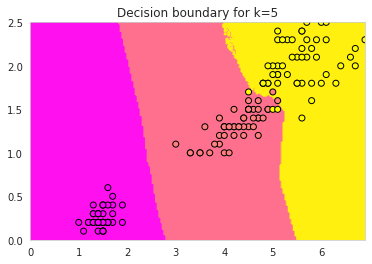

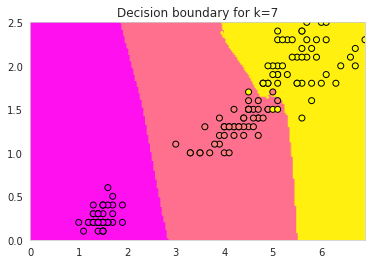

In [28]:
iris_x = np.array(iris_df[['petal_length', 'petal_width']])
iris_y = np.array(iris_df['target'])


mesh_x, mesh_y = np.meshgrid(np.linspace(
    0, max(iris_x[:, 0]), 200), np.linspace(0, max(iris_x[:, 1]), 200))

#use np.unique with suitable options to map the class names to numbers
target_names, iris_y_ids = np.unique(iris_y, return_inverse=True)

mesh_data = np.hstack([mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)])

preds = KNN(iris_x, iris_y_ids, mesh_data, [1, 3, 5, 7])
for k, preds_k in preds.items():
    plt.figure()
    plt.title(f"Decision boundary for k={k}")
    plt.contourf(mesh_x, mesh_y, preds_k.reshape(200, 200), cmap='spring')
    plt.scatter(iris_x[:, 0], iris_x[:, 1], c=iris_y_ids, edgecolors='black', cmap='spring')


### Estimate performance for various ks [1p]
Consider the following experiment (bootsrap error estimation):
1. We sample **with replacement** a dataset equal in size to the amount of data we have (i.e. for Iris, we pick 150 examples). This forms a trainign set. Since we have sampled with replacement, some samples were picked multiple times, and some were left out. Form a test set from the remaining ones.
2. Based on the training set, we use the k-NN algorithm to predict the labels on the test set.
3. We then check the number of errors and write it down.

Do this 500 times for k ∈ {1, 3, 5, ..., 19}. Plot a function of the average number of errors as the function of k. It should be similar to one of the plots below.

In [10]:
#TODO: write a function to compute error rates
def err_rates(preds, test_Y):
    ret = {}
    for k, preds_k in  preds.items():
        # TODO: fill in error count computation
        ret[k] = np.sum(preds_k != test_Y) / len(test_Y)
    return ret


100%|██████████| 1000/1000 [00:39<00:00, 25.15it/s]


<AxesSubplot:xlabel='K', ylabel='err_rate'>

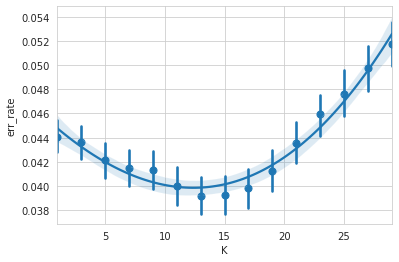

In [14]:
iris_x = np.array(iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
iris_y = np.array(iris_df['target'])

ks = range(1, 30, 2)
results = []

for _rep in tqdm(range(1000)):
    # Use np.random.randint to get training indices
    # The find all unselected indices to form a test set 
    train_idx = np.random.randint(len(iris_x), size=len(iris_x))
    test_idx = np.setdiff1d(list(range(len(iris_x))), train_idx)
    
    # apply your kNN classifier to data subset
    preds = KNN(iris_x[train_idx], iris_y[train_idx], iris_x[test_idx], ks)
    errs = err_rates(preds, iris_y[test_idx])
    
    for k, errs_k in errs.items():
        results.append({'K':k, 'err_rate': errs_k})

# results_df will be a data_frame in long format
results_df = pd.DataFrame(results)

plt.figure()
sns.regplot(x='K', y='err_rate', data=results_df, x_estimator=np.mean, order=3)


Implement the k-NN algorithm with a leave-one-out error estimation 

**Hint**: except for couple of lines the code for the KNN_loo function is very much the same as in previous Problem

Then perform two experiments:
1. plot the leave-one-out error rate as a function of $K$
2. choose K=15, plot the leave-one-out error rate as a function of training dataset size. For best results, repeat the experiment 100 times with different permutations of the dataset.

## Problem 2 kNN leave-one-out [2p]

In [16]:
from collections import defaultdict


def KNN_loo(train_X, train_Y, ks, verbose=False):

    results = []
    errs = defaultdict(int)
    for idx in range(len(train_X)):
        if verbose:
            print(idx)

        train_idx = np.array([i for i in range(len(train_X)) if i != idx])
        test_idx = [idx]

        if verbose:
            print(train_idx)
            print(test_idx)

        preds = KNN(train_X[train_idx], train_Y[train_idx], train_X[test_idx], ks)
        errs_tmp = err_rates(preds, train_Y[test_idx])

        if verbose:
            print(errs_tmp)

        for k, errs_k in errs_tmp.items():
            errs[k] += errs_k

    for k, errs_k in errs.items():
        results.append({'K': k, 'err_rate': errs_k / len(train_X)})

    return results


     K  err_rate
0    1  0.040000
1    3  0.040000
2    5  0.033333
3    7  0.033333
4    9  0.033333
5   11  0.033333
6   13  0.033333
7   15  0.026667
8   17  0.026667
9   19  0.020000
10  21  0.033333
11  23  0.033333
12  25  0.033333
13  27  0.033333
14  29  0.046667


<AxesSubplot:xlabel='K', ylabel='err_rate'>

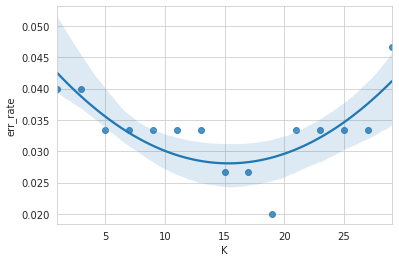

In [18]:

results_df = pd.DataFrame(KNN_loo(iris_x, iris_y, ks))
print(results_df)

plt.figure()
sns.regplot(x='K', y='err_rate', data=results_df, order=2)


     trainset_size  err_rate
0                5  1.000000
1               10  0.400000
2               20  0.600000
3               50  0.100000
4               75  0.053333
..             ...       ...
695             20  0.450000
696             50  0.040000
697             75  0.040000
698            100  0.060000
699            150  0.026667

[700 rows x 2 columns]


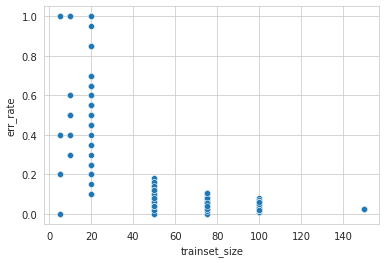

In [21]:
trainset_size = [5, 10, 20, 50, 75, 100, 150]
K = [15]
results = []

for _ in range(100):
    for size in trainset_size:
        permutation = np.random.permutation(len(iris_x))[:size]
        res = KNN_loo(iris_x[permutation], iris_y[permutation], K)[0]
        results.append({'trainset_size': size, 'err_rate': res['err_rate']})

results_df = pd.DataFrame(results)
print(results_df)
plt.figure()
splot = sns.scatterplot(data=results_df, x='trainset_size', y='err_rate')


## Problem 3 kNN MNIST [2p] 

Apply the K-Nearest Neighbors (K-NN) algorithm to the MNIST dataset. 

The MNIST (http://yann.lecun.com/exdb/mnist/) dataset consists of normalized (centered and stretched) scans of hand-written digits. Specifically, each element of the dataset is a 28 × 28 grayscale image, thus having 764 8-bit pixels. 

1. Display a few objects from each of the classes, paying attention to aesthetics and clarity of your presentation. **Note:** You already downloaded the dataset in "Setup" section. Please use the code below to get started.

2. **[2p]** Apply a k-NN classifier to the MNIST dataset. First, divide the training set into two parts, which we will call training and validation. On MNIST use the first 50000 samples for training and the last 10000 for validation. Then find the optimal number of neighbors by assessing the accuracy on the validation set. You do not need to repeat this experiment multiple times. Finally, compute the accuracy on the test set obtained with the best previously chosen number of neighbors. On MNIST you should get about 3% errors. Pick a few mislabeled samples from the test dataset and plot them along with the correct ones. **Note:**
  * MNIST is much larger than the Iris dataset. A good implementation may need a few minutes depending on your runtime type. Please optimize your algorithm:
  * Compute the distances only once, then test for different values of k.
  * Use vectorized expressions to compute the distance. It is possible to compute all distances between the training and testing points in one expression. Hint: think about the vectorized expression \begin{equation}(X - Y)^T (X - Y)\end{equation}
  * You can use single precision numbers in computation.
  * If your code is taking a long time to execute, please save its results before the lab session.

**Note:** in NumPy, matrices have its own data type (dtype), which is retained during
calculations. Please pay attention to it. I particular, do not subtract values of data types not
having the sign bit, do not divide integers, etc. Results of such operations will not be
automatically casted to types having the required precision.

In [22]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

In [23]:
with np.load('mnist.npz') as data:
    mnist_full_train_data_uint8 = data['train_data']
    mnist_full_train_labels_int64 = data['train_labels']
    mnist_test_data_uint8 = data['test_data']
    mnist_test_labels_int64 = data['test_labels']
        
# Split train data into train and validation sets
mnist_train_data_uint8 = mnist_full_train_data_uint8[:50000]
mnist_train_labels_int64 = mnist_full_train_labels_int64[:50000]
mnist_valid_data_uint8 = mnist_full_train_data_uint8[50000:]
mnist_valid_labels_int64 = mnist_full_train_labels_int64[50000:]

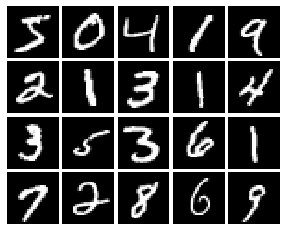

In [24]:
plot_mat(mnist_train_data_uint8[:20, None], cmap='gray')

In [25]:
# MNIST is large.
# Implement a batched KNN classifier, which processes the test data in small batches
# and returns the error rates

# The code should not run for more than a couple of minutes on the Colab runtime, 
# If it is slower, optimize the distance computation in KNN

def batched_KNN(train_X, train_Y, test_X, ks, verbose=False, batch_size=200):
    all_preds = {k: [] for k in ks}
    for i in tqdm(range(0, test_X.shape[0], batch_size)):
        batch_X = test_X[i:i + batch_size]
        
        # TODO: run KNN on the batch and save the predictions
        preds = KNN(train_X, train_Y, batch_X, ks)
        for k in all_preds.keys():
            # TODO: combine predictions from batches
            all_preds[k] = np.concatenate((all_preds[k], preds[k]))
    return all_preds


100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


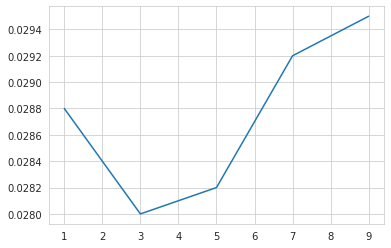

In [26]:
# Now find the best k on the validation set
ks = [1, 3, 5, 7, 9]
mnist_validation_preds = batched_KNN(
    mnist_train_data_uint8.astype('float32').reshape(-1, 28*28), mnist_train_labels_int64,
    mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28),
    ks)

mnist_validation_errs = err_rates(mnist_validation_preds, mnist_valid_labels_int64)
plt.plot(ks, [mnist_validation_errs[k] for k in ks])

In [27]:
# Now use the best k to compute the test error

best_K = 3

mnist_test_preds = batched_KNN(
    mnist_full_train_data_uint8.astype('float32').reshape(-1, 28*28), 
    mnist_full_train_labels_int64,
    mnist_test_data_uint8.astype('float32').reshape(-1, 28*28), 
    [best_K])

mnist_test_errs = err_rates(mnist_test_preds, mnist_test_labels_int64)
print(f"\n\nWhen k={best_K} the test error rate is {mnist_test_errs[best_K] * 100.0:.1f}%%")

100%|██████████| 50/50 [01:43<00:00,  2.08s/it]



When k=3 the test error rate is 2.9%%
